# Analze_annotations_agreement between humans and model(s). 
### note also the seperate set of negatives
* `Real`


In [1]:
# SAVE = True
USE_ALT = False # try another set of model preds

SAVE = False 
# USE_ALT = True

In [2]:
import pandas as pd
from scipy.stats import pearsonr, ttest_ind
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, accuracy_score
import numpy as np
import seaborn as sns
# %matplotlib inline

# Load the human annotations and model annotations files
human_annotations_oesophagus_1 = pd.read_excel('./Outputs/annotaters_results/Palsi-FILL-oesophagus_candidates.xlsx').dropna(thresh=12,axis=1)
human_annotations_gallstone = pd.read_excel('./Outputs/annotaters_results/Pasi_gallstone_candidates.xlsx').dropna(thresh=12,axis=1)
model_annotations_oesophagus = pd.read_csv('./Outputs/annotators_input/uncensored/oesophagus_candidates_uncensored.csv',index_col=[0]).dropna(thresh=12,axis=1)
model_annotations_gallstone = pd.read_csv('./Outputs/annotators_input/uncensored/gallstone_candidates_uncensored.csv',index_col=[0]).dropna(thresh=12,axis=1)

human_oesophagus_2 = pd.read_excel('./Outputs/annotaters_results/SHAI_oesophagus.xlsx').dropna(thresh=12,axis=1)


human_gout = pd.read_csv('./Outputs/annotaters_results/gout_candidates-TALI.csv')
model_gout = pd.read_csv('./Outputs/annotators_input/uncensored/gout_candidates_uncensored.csv',index_col=[0]).dropna(thresh=12,axis=1)
# Inspecting the data structures to understand their formats


In [3]:
# human_annotations_oesophagus.set_index("Feature_Name").select_dtypes(["number","boolean"]).dropna().to_csv("palse_oes.csv")
# human_oesophagus_2.set_index("Feature_Name").select_dtypes(["number","boolean"]).dropna().to_csv("shai_oes.csv")

In [4]:
print(human_annotations_oesophagus_1.shape)
human_annotations_oesophagus = pd.concat([human_annotations_oesophagus_1,human_oesophagus_2])
print(human_annotations_oesophagus.shape)
print(human_annotations_oesophagus.drop_duplicates().shape[0])

(52, 9)
(104, 9)
104


In [5]:
if USE_ALT:
    model_annotations_oesophagus = pd.read_csv("./Outputs/O1_esophagus.csv").rename(columns={'Novelty':"novel","Interestingness":"Interesting",
                                                                                            "Plausibility":"plausible"})
    model_annotations_oesophagus["confidence"] = model_annotations_oesophagus["Interesting"]
    model_annotations_gallstone = pd.read_csv("./Outputs/O1_gallstones.csv").rename(columns={'Novelty':"novel","Plausibility":"plausible",
                                                                                             "Interestingness":"Interesting"})
    model_annotations_gallstone["confidence"] = model_annotations_gallstone["Interesting"]
    
    print(model_annotations_oesophagus.shape)
    print(model_annotations_oesophagus.columns)
    
    print(model_annotations_gallstone.shape)
    print(model_annotations_gallstone.columns)

#### ALT
* I did another seperate alt experiment of using just gpt 01, without rag, on the cases we had pickedfor annotation.
* Ran on all cases at once and output csv.
Prompt was:
```
(List of annotator instructions, likewe gave annotators)
```

```
Annotate and explain the following list of features for novelty, plausability, utility and Interestingness.  
Target disease for all these features is: Cancer of the esophagus/ Oesophagal cancer.

Return as a list (for a csv), one row per feature, including the feature's original name, a strong explanation + justification,  and your 1-4 scale annotations per label. Do not be lazy, think about each candidate carefully and deeply, especially if it is interesting enough to potentially merit further scientific or clinical research. You may freely ignore the provided comments/explanations for each feature, if you know better or more. Consider diverse causal, social, physiological, economic, clinical (e.g. lifestyle) and biological pathways and mechanisms, known literature (which may be wrong! As you are an expert researcher, these features we review may represent novel insights and discoveries) as well as expert medical knowledge and understandings that may be of relevance in explaining or justifying or refuting each feature, or understanding if they are truly exciting and interesting.  
```

In [6]:
## at least for these diseases, all candidates were annotated as novel by the model itself
print(model_annotations_oesophagus.novel.value_counts())
print(model_annotations_gallstone.novel.value_counts())
print(model_gout.novel.value_counts())

novel
1.0    44
Name: count, dtype: int64
novel
1.0    43
Name: count, dtype: int64
novel
1.0    50
Name: count, dtype: int64


In [7]:
model_annotations_gallstone.columns

Index(['Feature_Name', 'novel', 'novel_cot', 'plausible', 'plausible_cot',
       'Interesting?', 'Confidence', 'explanation', 'corr', 'p_val',
       'feature_importance', 'MutualInfoTarget', 'F.Split-Lift (y==1)',
       'F.Split-Feature Split', 'not_boring', 'boring_cot', 'Target', 'Real',
       'Util_Explanation', 'Utility', 'Utility_Score', 'correlation'],
      dtype='object')

In [8]:
def compute_agreement(df1, df2, categories, binarize=False, bin_threshold=2):
    """
    Compute agreement metrics between two sets of annotators.

    Parameters:
    - df1, df2 (pd.DataFrame): DataFrames containing annotations from two different annotators.
    - categories (list of str): Columns in the DataFrame to compute the agreement metrics.
    - binarize (bool): Whether to binarize the scores (default: False).
    - bin_threshold (int): Threshold above which scores are considered high (1), else low (0).

    Returns:
    - pd.DataFrame: DataFrame containing correlation and Cohen's Kappa for each category.
    """
    # Merge the two DataFrames on the 'Feature_Name' to ensure alignment of features
    df_merged = pd.merge(df1, df2, on='Feature_Name', suffixes=('_Annotator1', '_Annotator2'),how="inner")
    df_merged.dropna(subset=[f'{cat}_Annotator1' for cat in categories] + [f'{cat}_Annotator2' for cat in categories], inplace=True)
    if binarize:
        for cat in categories:
            df_merged[f'{cat}_Annotator1'] = (df_merged[f'{cat}_Annotator1'] > bin_threshold).astype(int)
            df_merged[f'{cat}_Annotator2'] = (df_merged[f'{cat}_Annotator2'] > bin_threshold).astype(int)

    # Initialize a dictionary to hold the agreement metrics for each annotation category
    agreement_metrics = {
        'Category': [],
        'Correlation': [],
        'Cohen\'s Kappa': []
    }

    # Calculate the agreement metrics for each annotation category
    for category in categories:
        correlation = df_merged[f'{category}_Annotator1'].corr(df_merged[f'{category}_Annotator2'])
        kappa = cohen_kappa_score(df_merged[f'{category}_Annotator1'], df_merged[f'{category}_Annotator2'])

        agreement_metrics['Category'].append(category)
        agreement_metrics['Correlation'].append(correlation)
        agreement_metrics['Cohen\'s Kappa'].append(kappa)

    # Convert the results into a DataFrame for display
    return pd.DataFrame(agreement_metrics).round(2)

# Load the data again just in case
# df1 = pd.read_csv('/mnt/data/shai_oes.csv')
# df2 = pd.read_csv('/mnt/data/palse_oes.csv')
df1 = human_annotations_oesophagus_1
df2 =human_oesophagus_2

# Test the function without binarization
results_no_binarization = compute_agreement(df1, df2, categories=['Novel?', 'Plausible-Makes sense?', 'Utility?', 'Interesting?'], binarize=False)
# Test the function with binarization
results_binarization = compute_agreement(df1, df2, categories=['Novel?', 'Plausible-Makes sense?', 'Utility?', 'Interesting?'], binarize=True, bin_threshold=2)

results_no_binarization, results_binarization


(                 Category  Correlation  Cohen's Kappa
 0                  Novel?         0.41           0.09
 1  Plausible-Makes sense?        -0.01          -0.03
 2                Utility?         0.10           0.09
 3            Interesting?         0.29           0.05,
                  Category  Correlation  Cohen's Kappa
 0                  Novel?         0.37           0.24
 1  Plausible-Makes sense?        -0.23          -0.18
 2                Utility?         0.09           0.08
 3            Interesting?         0.36           0.28)

In [9]:
# Improved preprocessing function for harmonization and normalization
import pandas as pd
import numpy as np

def preprocess_and_separate(human_df, model_df):
    """
    Preprocess and normalize human and model annotation data.
    Harmonize column names, merge datasets, and separate real and distractor features.

    Args:
    - human_df: DataFrame containing human annotations.
    - model_df: DataFrame containing model annotations.

    Returns:
    - real_features: DataFrame with real features.
    - distractors: DataFrame with distractor features.
    """
    ## opt : filter input columns
    # human_df = human_df[['Feature_Name', 'explanation',  'Target', 'Comments',
    #    'Novel?', 'Plausible-Makes sense?', 'Utility?', 'Interesting?']

    # Normalize column names
    human_df.columns = human_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('?', '').str.strip()
    model_df.columns = model_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('?', '').str.strip()
    ## target - free text changed in human versions so not great for naive merge
    human_df.drop(columns=["explanation",'target',"correlation"],errors="ignore",inplace=True) # explanation is model explanation given to humans. "Comments" is technically human xplanation
    human_df.rename(columns={'plausible-makes_sense': 'plausible',"utility":"utility_human"},inplace=True)

    model_df.rename(columns={"confidence":"confidence_model","utility":"utility_model"},inplace=True)
    # Merge datasets
    merged = pd.merge(human_df, model_df, on='feature_name', suffixes=('_human', '_model'))

    # Convert 'real' column to boolean if present
    if 'real' in merged.columns:
        merged['real'] = merged['real'].astype(bool)
    else:
        raise ValueError(f"Column 'real' is missing in the model annotations ")

    # Separate real and distractor features
    real_features = merged[merged['real']]
    distractors = merged[~merged['real']]

    return real_features, distractors

# Apply the preprocessing to the oesophagus and gallstone datasets
real_oesophagus, distractors_oesophagus = preprocess_and_separate(
    human_annotations_oesophagus, model_annotations_oesophagus)
real_gallstone, distractors_gallstone = preprocess_and_separate(
    human_annotations_gallstone, model_annotations_gallstone)
real_gout, distractors_gout = preprocess_and_separate(
    human_gout, model_gout)
# human_gout model_gout

In [10]:
KEEP_ANALYZE_COLS_LIST = ['feature_name', 'comments', 'novel_human', 'plausible_human', 'utility_human',
       'interesting_human', 'novel_model', 
                          # 'novel_cot', 'plausible_cot', 
                          'plausible_model',
       'interesting_model', 'confidence_model', 'explanation',
       'corr', 'p_val', 'feature_importance', 'mutualinfotarget', 'target', 'real',
               "utility_model"]
df_real = pd.concat([real_oesophagus,real_gallstone,real_gout],ignore_index=True)[KEEP_ANALYZE_COLS_LIST]
real_df = df_real
fake_df = pd.concat([distractors_gallstone,distractors_oesophagus,distractors_gout],ignore_index=True)[KEEP_ANALYZE_COLS_LIST]
# real_gallstone[['feature_name', 'comments', 'novel_human', 'plausible_human', 'utility_human',
#        'interesting_human', 'novel_model', 'novel_cot', 'plausible_model',
#        'plausible_cot', 'interesting_model', 'confidence_model', 'explanation',
#        'corr', 'p_val', 'feature_importance', 'mutualinfotarget', 'target', 'real']].to_csv("gallstone_compare.csv",index=False)

if SAVE:
    df_real.to_csv("./Outputs/analyses/real_compare.csv",index=False)
    fake_df.to_csv("./Outputs/analyses/fake_compare.csv",index=False)

In [11]:
[c for c in KEEP_ANALYZE_COLS_LIST if c not in real_oesophagus.columns]

[]

In [12]:
# df_real = pd.read_csv("./Outputs/analyses/real_compare.csv")
df_real.shape[0]

181

### rejoin fake and real datasets

In [13]:
# Harmonize and validate data
def harmonize_data(fake_df, real_df):
    """
    Harmonize column names and validate consistency between fake and real datasets.

    Args:
    - fake_df: DataFrame containing fake results.
    - real_df: DataFrame containing real results.

    Returns:
    - Combined and validated DataFrame with fake and real data labeled.
    """
    # Normalize column names
    fake_df.columns = fake_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('?', '')
    real_df.columns = real_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('?', '')

    # Add dataset identifier
    fake_df['dataset'] = 'fake'
    real_df['dataset'] = 'real'

    # Combine datasets
    combined = pd.concat([fake_df, real_df], ignore_index=True)
    combined['real'] = combined['real'].astype(bool)  # Ensure 'real' is boolean
    
    combined['interesting_model'] = pd.to_numeric(combined[ 'interesting_model'],downcast="float") # make boolean number
    combined['utility_model'] = pd.to_numeric(combined[ 'utility_model'],downcast="float") # make boolean number
    combined = combined.dropna(how="all",axis=1).dropna(how="all",axis=0)
    # Verify necessary columns
    required_columns = ['novel_human', 'plausible_human', 'utility_human', 'interesting_human',
                        'novel_model', 'plausible_model', 'utility_model', 'interesting_model', 'real']
    missing_columns = [col for col in required_columns if col not in combined.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    return combined

# Harmonize the fake and real datasets
combined_data = harmonize_data(fake_df=fake_df, real_df=df_real)


#### 1. Statistical Summaries
    Compare mean and standard deviation of human and model scores across novel, plausible, and interesting categories for:
    Real features (real = True).
    Fake features (real = False).
#### 2. Agreement Metrics
    Compute agreement metrics for real features:
    Pearson Correlation: Assess linear alignment of human and model scores.
    Cohen’s Kappa and MCC: Evaluate binary agreement after thresholding (e.g., score ≥ 3 as positive).
#### 3. Visualizations
    Distributions: Histograms for score distributions of humans and models.
    Agreement: Scatter plots of human vs. model scores.
    Comparison: Boxplots to compare fake and real scores.
#### 4. Insights
    Highlight areas where the model aligns well with humans.
    Identify discrepancies and their implications for task complexity or model training.

##### analysis for Fake vs Real features.
* Humans judge Fake features are more novel, less plausible , less utility

In [14]:
combined_data.real.sum()

181

In [15]:
combined_data.describe().round(2)

,novel_human,plausible_human,utility_human,interesting_human,novel_model,plausible_model,interesting_model,confidence_model,corr,p_val,feature_importance,mutualinfotarget,utility_model
count,198.00,197.00,197.00,197.00,181.0,181.00,181.00,181.00,215.00,215.00,215.00,215.00,155.0
mean,2.78,2.41,1.86,2.05,1.0,0.25,0.99,3.32,-0.00,0.15,0.01,0.00,0.2
std,1.02,0.94,0.71,0.79,0.0,0.43,0.07,0.47,0.03,0.28,0.02,0.00,0.4
min,1.00,1.00,1.00,1.00,1.0,0.00,0.00,3.00,-0.15,0.00,0.00,0.00,0.0
25%,2.00,2.00,1.00,1.00,1.0,0.00,1.00,3.00,-0.01,0.00,0.00,0.00,0.0
50%,3.00,2.00,2.00,2.00,1.0,0.00,1.00,3.00,0.00,0.00,0.00,0.00,0.0
75%,4.00,3.00,2.00,3.00,1.0,0.00,1.00,4.00,0.02,0.14,0.01,0.00,0.0
max,4.00,4.00,4.00,4.00,1.0,1.00,1.00,4.00,0.12,1.00,0.16,0.03,1.0


In [16]:
combined_data.reindex(sorted(combined_data.columns), axis=1).groupby("real").mean(numeric_only=True).round(2)

,confidence_model,corr,feature_importance,interesting_human,interesting_model,mutualinfotarget,novel_human,novel_model,p_val,plausible_human,plausible_model,utility_human,utility_model
real,,,,,,,,,,,,,
False,NaN,-0.0,0.00,1.81,NaN,0.0,2.82,NaN,0.72,2.12,NaN,1.48,0.25
True,3.32,-0.0,0.01,2.09,0.99,0.0,2.78,1.0,0.05,2.46,0.25,1.94,0.19


In [17]:
combined_data.loc[combined_data["real"]].mean(numeric_only=True).round(2).sort_index()

confidence_model      3.32
corr                 -0.00
feature_importance    0.01
interesting_human     2.09
interesting_model     0.99
mutualinfotarget      0.00
novel_human           2.78
novel_model           1.00
p_val                 0.05
plausible_human       2.46
plausible_model       0.25
real                  1.00
utility_human         1.94
utility_model         0.19
dtype: float64

In [18]:
combined_data.reindex(sorted(combined_data.columns), axis=1).groupby("real").mean(numeric_only=True).round(2)

,confidence_model,corr,feature_importance,interesting_human,interesting_model,mutualinfotarget,novel_human,novel_model,p_val,plausible_human,plausible_model,utility_human,utility_model
real,,,,,,,,,,,,,
False,NaN,-0.0,0.00,1.81,NaN,0.0,2.82,NaN,0.72,2.12,NaN,1.48,0.25
True,3.32,-0.0,0.01,2.09,0.99,0.0,2.78,1.0,0.05,2.46,0.25,1.94,0.19


In [19]:
# combined_data.query("~real")
combined_data.shape

(215, 19)

real
False    [[Axes(0.125,0.11;0.775x0.77)]]
True     [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

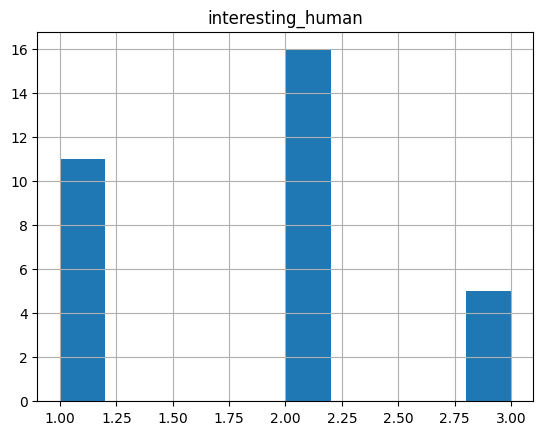

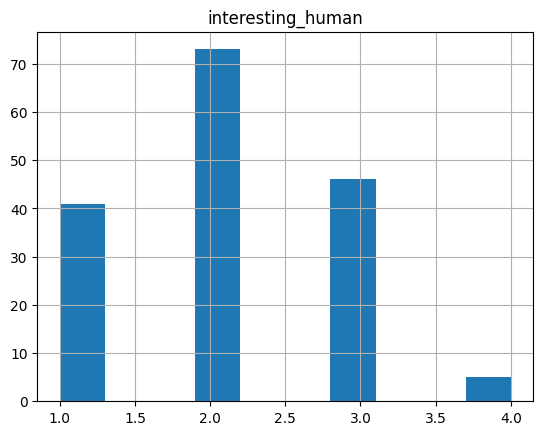

In [20]:
combined_data[["real","interesting_human"]].groupby("real").hist()
# combined_data.query("~real")["interesting_human"].hist()

In [21]:
def compute_statistics_and_agreement_with_validation(data):
    """
    Compute statistical summaries and agreement metrics with thorough validation
    to handle edge cases in correlation calculation.

    Args:
    - data: Combined DataFrame of fake and real results.

    Returns:
    - stats_summary: DataFrame summarizing statistics for fake and real features.
    - agreement_metrics: Dictionary of agreement metrics for real features.
    """
    # Filter real and fake features
    real_features = data[data['real']]
    fake_features = data[~data['real']]

    # Categories for analysis
    categories = ['novel_human', 'plausible_human', 'interesting_human']
    model_columns = ['novel_model', 'plausible_model', 'interesting_model']

    # Statistical summaries
    summary = []
    for human_col, model_col in zip(categories, model_columns):
        # Compute metrics for real features
        real_scores = real_features[[human_col, model_col]].dropna()
        fake_scores = fake_features[[human_col, model_col]].dropna()

        # Mean and standard deviation
        real_mean_human = real_scores[human_col].mean()
        real_mean_model = real_scores[model_col].mean()
        real_std_human = real_scores[human_col].std()
        real_std_model = real_scores[model_col].std()

        fake_mean_human = fake_scores[human_col].mean()
        fake_mean_model = fake_scores[model_col].mean()

        # T-tests
        ttest_human = ttest_ind(real_scores[human_col], fake_scores[human_col], nan_policy='omit', equal_var=False)
        ttest_model = ttest_ind(real_scores[model_col], fake_scores[model_col], nan_policy='omit', equal_var=False)

        summary.append({
            'Category': human_col,
            'Real Mean (Human)': real_mean_human,
            'Real Std (Human)': real_std_human,
            'Real Mean (Model)': real_mean_model,
            'Real Std (Model)': real_std_model,
            'Fake Mean (Human)': fake_mean_human,
            'Fake Mean (Model)': fake_mean_model,
            'T-Test p-value (Human)': ttest_human.pvalue,
            'T-Test p-value (Model)': ttest_model.pvalue,
        })

    # Agreement metrics
    agreement_metrics = {}
    for human_col, model_col in zip(categories, model_columns):
        real_scores = real_features[[human_col, model_col]].dropna()
        if not real_scores.empty:
            # Extract human and model values
            human_values = real_scores[human_col]
            model_values = real_scores[model_col]

            # Validate numeric data
            if not pd.api.types.is_numeric_dtype(human_values) or not pd.api.types.is_numeric_dtype(model_values):
                print(f"Non-numeric data found in columns {human_col} or {model_col}. Skipping correlation.")
                correlation = np.nan
            elif len(human_values) > 1 and len(model_values) > 1:
                # Compute correlation safely
                correlation = human_values.corr(model_values)
            else:
                correlation = np.nan  # Undefined for insufficient data

            # Binary agreement metrics
            binary_human = (human_values >= 3).astype(int)
            binary_model = (model_values >= 3).astype(int)
            kappa = cohen_kappa_score(binary_human, binary_model)
            mcc = matthews_corrcoef(binary_human, binary_model)

            agreement_metrics[human_col] = {
                'Pearson Correlation': correlation,
                'Cohen Kappa': kappa,
                'MCC': mcc
            }

    stats_summary = pd.DataFrame(summary)
    return stats_summary, agreement_metrics


# # Perform statistical analysis with validation
# stats_summary_validated, agreement_metrics_validated = compute_statistics_and_agreement_with_validation(combined_data)

# # Display the statistical summaries
# tools.display_dataframe_to_user(name="Statistical Summary (Validated)", dataframe=stats_summary_validated)

# # Display agreement metrics
# agreement_metrics_validated


def refine_preprocessing(data):
    """
    Refine preprocessing by standardizing data types, handling non-numeric entries,
    and logging changes for transparency.

    Args:
    - data: Combined DataFrame of fake and real results.

    Returns:
    - Refined DataFrame with standardized and validated data.
    """
    refined_data = data.copy()

    # Ensure all score columns are numeric
    score_columns = ['novel_human', 'plausible_human', 'interesting_human',
                     'novel_model', 'plausible_model', 'interesting_model',
                    'utility_human', 'utility_model',]
    
    for col in score_columns:
        # Convert to numeric and log non-numeric entries
        refined_data[col] = pd.to_numeric(refined_data[col], errors='coerce')
        non_numeric_count = refined_data[col].isna().sum()
        if non_numeric_count > 0:
            print(f"Column '{col}': {non_numeric_count} non-numeric entries converted to NaN.")

    # Remove rows where all scores are missing
    refined_data.dropna(subset=score_columns, how='all', inplace=True)

    # Log constant columns
    for col in score_columns:
        if refined_data[col].nunique() == 1:
            print(f"Column '{col}' contains constant values: {refined_data[col].iloc[0]}")

    # # Remove extreme outliers (e.g., outside 1.5 * IQR range)
    # for col in score_columns:
    #     if refined_data[col].nunique() > 1:  # Exclude constant columns
    #         q1 = refined_data[col].quantile(0.1)
    #         q3 = refined_data[col].quantile(0.9)
    #         iqr = q3 - q1
    #         lower_bound = q1 - 1.5 * iqr
    #         upper_bound = q3 + 1.5 * iqr
    #         outliers = refined_data[(refined_data[col] < lower_bound) | (refined_data[col] > upper_bound)]
    #         if not outliers.empty:
    #             print(f"Column '{col}' has {len(outliers)} outliers removed.")
    #             refined_data = refined_data[~((refined_data[col] < lower_bound) | (refined_data[col] > upper_bound))]

    return refined_data


# Apply refined preprocessing to the combined dataset
refined_data = refine_preprocessing(combined_data)

# Display the refined dataset user for review
display(refined_data)

Column 'novel_human': 17 non-numeric entries converted to NaN.
Column 'plausible_human': 18 non-numeric entries converted to NaN.
Column 'interesting_human': 18 non-numeric entries converted to NaN.
Column 'novel_model': 34 non-numeric entries converted to NaN.
Column 'plausible_model': 34 non-numeric entries converted to NaN.
Column 'interesting_model': 34 non-numeric entries converted to NaN.
Column 'utility_human': 18 non-numeric entries converted to NaN.
Column 'utility_model': 60 non-numeric entries converted to NaN.
Column 'novel_model' contains constant values: nan


,feature_name,comments,novel_human,plausible_human,utility_human,interesting_human,novel_model,plausible_model,interesting_model,confidence_model,explanation,corr,p_val,feature_importance,mutualinfotarget,target,real,utility_model,dataset
0,Actinic keratosis,also prevalent in fair-skins,4.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,Actinic keratosis is interesting because it ha...,0.003,0.948,0.000,0.000,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,False,0.0,fake
1,Z90.7 - Acquired absence of genital organ(s),pregnancy is risk factor,3.0,2.0,3.0,3.0,NaN,NaN,NaN,NaN,The feature 'Z90.7 - Acquired absence of genit...,0.004,0.883,0.002,0.001,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,False,0.0,fake
2,M79.66 - Pain in limb (Lower leg),-,4.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,The feature 'M79.66 - Pain in limb (Lower leg)...,0.001,0.819,0.000,0.000,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,False,0.0,fake
3,Ever addicted to a behaviour or miscellanous_Yes,-,4.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,The feature 'Ever addicted to a behaviour or m...,-0.001,0.672,0.000,0.000,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,False,0.0,fake
4,"Epilepsy, recurrent seizures, convulsions",-,3.0,3.0,2.0,3.0,NaN,NaN,NaN,NaN,"The feature 'Epilepsy, recurrent seizures, con...",0.001,0.873,0.000,0.000,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,False,0.0,fake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Vitamin D,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,3.0,1. **Novelty:** The association between Vitami...,-0.013,0.000,0.008,0.001,Gout,True,NaN,real
211,Concentration of Chylomicrons and Extremely La...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,4.0,The feature 'Concentration of Chylomicrons and...,0.029,0.000,0.002,0.000,Gout,True,NaN,real
212,(MEL) melanoma genetic risk,more cancers in Gout,2.0,3.0,2.0,2.0,1.0,0.0,1.0,3.0,1. **Novelty:** The association between melano...,0.004,0.219,0.004,0.000,Gout,True,NaN,real
213,Had major operations_No,NaN,1.0,4.0,2.0,1.0,1.0,0.0,1.0,3.0,The feature 'Had major operations' is negative...,-0.019,0.000,0.006,0.003,Gout,True,NaN,real


## Table 3. Comparison of Human Annotation Scores Between Real and Fake Features.

In [22]:
from scipy.stats import ttest_ind

def analyze_statistical_significance(data, group_column, score_columns):
    """
    Perform statistical tests to determine significant differences between groups.

    Args:
    - data: DataFrame containing the data.
    - group_column: The column to group by (e.g., "real").
    - score_columns: List of numeric columns to test.

    Returns:
    - summary_df: DataFrame summarizing mean scores and statistical significance (p-values).
    """
    # Split data into groups
    group_true = data[data[group_column] == True]
    group_false = data[data[group_column] == False]

    assert group_false.shape[0]>0
    assert group_true.shape[0]>0

    # Initialize results list
    results = []

    for col in score_columns:
        # Calculate group means
        mean_true = group_true[col].mean()
        mean_false = group_false[col].mean()

        # Perform t-test
        t_stat, p_value = ttest_ind(
            group_true[col].dropna(), group_false[col].dropna(), nan_policy='omit', equal_var=False
        )

        # Append results
        results.append({
            "Annotation": col,
            "Mean (Real)": round(mean_true, 3),
            "Mean (Fake)": round(mean_false, 3),
            "p-Value": round(p_value, 4),
            "Significant": "Yes" if p_value < 0.05 else "No",
        })

    # Convert results to DataFrame
    summary_df = pd.DataFrame(results)
    summary_df = summary_df.replace({"novel_human":"Novel","plausible_human":"Plausibility",
                                           "utility_human":"Utility","interesting_human":"Interestingness"}).round(4)
    return summary_df

#### Table 3 - real vs fake scores

In [23]:
refined_data["real"].value_counts()

real
True     181
False     34
Name: count, dtype: int64

In [ ]:
# Columns to analyze
score_columns = ['novel_human', 'plausible_human','utility_human', 'interesting_human',
                 'novel_model', 'plausible_model', 'interesting_model']

# try:
# Perform statistical analysis
stat_significance_results = analyze_statistical_significance(refined_data, "real", score_columns)

# Display results in a nice format for publication
display(stat_significance_results.round(4))
# except:()

#### Human annotators scores by target

In [25]:
refined_data.groupby(["target","real"]).mean(numeric_only=True).round(2).iloc[:,0:8]

novel_human  \
target                                             real                 
(Cholelithiasis) OR (Gallstone) OR (Gallbladder... False         3.75   
                                                   True          2.90   
Gout                                               False         2.00   
                                                   True          2.46   
oesophagus cancer                                  False         2.87   
                                                   True          2.84   

                                                          plausible_human  \
target                                             real                     
(Cholelithiasis) OR (Gallstone) OR (Gallbladder... False             2.12   
                                                   True              2.88   
Gout                                               False             2.60   
                                                   True              3.14   
oesophagus cancer                                  False             1.80   
                                                   True              1.99   

                                                          utility_human  \
target                                             real                   
(Cholelithiasis) OR (Gallstone) OR (Gallbladder... False           2.00   
                                                   True            2.02   
Gout                                               False           1.30   
                                                   True            1.94   
oesophagus cancer                                  False           1.33   
                                                   True            1.90   

                                                          interesting_human  \
target                                             real                       
(Cholelithiasis) OR (Gallstone) OR (Gallbladder... False               2.25   
                                                   True                2.38   
Gout                                               False               1.44   
                                                   True                2.08   
oesophagus cancer                                  False               1.80   
                                                   True                1.95   

                                                          novel_model  \
target                                             real                 
(Cholelithiasis) OR (Gallstone) OR (Gallbladder... False          NaN   
                                                   True           1.0   
Gout                                               False          NaN   
                                                   True           1.0   
oesophagus cancer                                  False          NaN   
                                                   True           1.0   

                                                          plausible_model  \
target                                             real                     
(Cholelithiasis) OR (Gallstone) OR (Gallbladder... False              NaN   
                                                   True              0.44   
Gout                                               False              NaN   
                                                   True              0.36   
oesophagus cancer                                  False              NaN   
                                                   True              0.09   

                                                          interesting_model  \
target                                             real                       
(Cholelithiasis) OR (Gallstone) OR (Gallbladder... False                NaN   
                                                   True                0.98   
Gout                                               False                NaN   
                         

In [26]:
##without tali
analyze_statistical_significance(refined_data.loc[refined_data["target"].str.contains("cancer",case=False)], "real", score_columns)

,Annotation,Mean (Real),Mean (Fake),p-Value,Significant
0,Novel,2.84,2.87,0.93,No
1,Plausibility,1.99,1.80,0.34,No
2,Utility,1.90,1.33,0.00,Yes
3,Interestingness,1.95,1.80,0.44,No
4,novel_model,1.00,NaN,NaN,No
5,plausible_model,0.09,NaN,NaN,No
6,interesting_model,1.00,NaN,NaN,No


In [27]:
print(stat_significance_results.dropna().replace({"novel_human":"Novel","plausible_human":"Plausibility",
                                           "utility_human":"Utility","interesting_human":"Interestingness",
                                           "Score":"Annotation"}).drop(columns=["Significant"]).to_latex(index=False,
                  formatters={"name": str.upper},float_format="{:.2f}".format))

\begin{tabular}{lrrr}
\toprule
Annotation & Mean (Real) & Mean (Fake) & p-Value \\
\midrule
Novel & 2.78 & 2.82 & 0.84 \\
Plausibility & 2.46 & 2.12 & 0.04 \\
Utility & 1.94 & 1.48 & 0.00 \\
Interestingness & 2.09 & 1.81 & 0.05 \\
\bottomrule
\end{tabular}



The compute_statistics_and_agreement_with_validation function is designed to:

##### Compare fake and real features:
    Compute mean, standard deviation, and statistical tests (t-tests) for human and model scores.
    Identify significant differences in how humans and models rate fake vs. real features.
    Evaluate agreement between humans and models:
    Calculate Pearson correlation for linear agreement.
    Assess binary classification agreement (Cohen's Kappa, MCC) after thresholding scores.
##### Outputs:
    Statistical Summary:
    Mean, standard deviation, and t-test p-values for fake vs. real scores.
    This provides insight into whether models or humans can differentiate between fake and real features.
    Agreement Metrics:
    Pearson correlation quantifies how well models align with human scores.
    Binary metrics (Cohen's Kappa and MCC) indicate agreement after binarization.

##### Review of Outputs
##### Statistical Summary:
    
    Strengths: The summary successfully highlights differences between fake and real features, especially in plausible scores.
    Weaknesses:
        Undefined or unreliable results for interesting, likely due to non-numeric values or low variability.
        Outputs lack a broader context for interpretation (e.g., effect size, practical significance).
##### Agreement Metrics:

    Strengths:
    Moderate Pearson correlation for plausible indicates partial alignment between humans and models.
    Weaknesses:
    Correlation and binary metrics for novel and interesting are either undefined or near-zero, limiting insights into model alignment.
    Binary metrics do not capture the nuances of continuous scoring differences.
    What Are We Testing/Answering?
##### Key Questions:

    Do humans and models distinguish between fake and real features?
    How well do models align with human scores across categories (novel, plausible, interesting)?
    Are there significant gaps in model performance, and what might explain them?
##### Insights Expected:

    Models are expected to align better with humans for structured tasks like plausible.
    Subjective or ambiguous categories (interesting) may exhibit weaker alignment.
    Real vs. fake distinctions in scores should highlight model limitations or strengths in identifying distractors.
##### What’s Lacking?
Data Quality:

    Non-numeric or invalid entries in interesting need preprocessing or annotation standardization.
    Check for systematic biases (e.g., uniformly high or low scores in certain datasets).
Visualizations:

    Scatter plots for agreement between humans and models can provide visual confirmation of trends.
    Boxplots and histograms can highlight differences in fake vs. real feature scores.
Additional Metrics:
    
    Effect sizes (e.g., Cohen's d) for t-tests can contextualize significance.
    A deeper exploration of annotation consistency between humans could reveal inter-rater reliability issues.
Contextual Interpretation:

    Relate findings to task complexity or model limitations (e.g., lack of training data for subjective categories).


In [28]:
real_df["interesting_model"] = pd.to_numeric(real_df["interesting_model"],downcast="float")
real_df["utility_model"] = pd.to_numeric(real_df["utility_model"],downcast="float")

combined_data["utility_model"] = pd.to_numeric(combined_data["utility_model"],downcast="float")

In [29]:
def compute_statistics_and_agreement_safe(data):
    """
    Safe version of statistical summaries and agreement metrics computation,
    ensuring proper handling of edge cases in correlation calculations.

    Args:
    - data: Combined DataFrame of fake and real results.

    Returns:
    - stats_summary: DataFrame summarizing statistics for fake and real features.
    - agreement_metrics: Dictionary of agreement metrics for real features.
    """
    data["interesting_model"] = pd.to_numeric(data["interesting_model"],downcast="float")
    data["utility_model"] = pd.to_numeric(data["utility_model"],downcast="float")
    # Filter real and fake features
    real_features = data[data['real']]
    fake_features = data[~data['real']]

    # Categories for analysis
    categories = ['novel_human', 'plausible_human', 'interesting_human',"utility_human"]
    # model_columns = ['novel_model', 'plausible_model', 'interesting_model',"utility_model",'confidence_model'] # was (before we added "utility" in btoh
    model_columns = ['novel_model', 'plausible_model', 'interesting_model',"utility_model"]  # try alt 
    
    # Statistical summaries
    summary = []
    for human_col, model_col in zip(categories, model_columns):
        # Compute metrics for real features
        real_scores = real_features[[human_col, model_col]].dropna()
        fake_scores = fake_features[[human_col, model_col]].dropna()

        # Mean and standard deviation
        real_mean_human = real_scores[human_col].mean()
        real_mean_model = real_scores[model_col].mean()
        real_std_human = real_scores[human_col].std()
        real_std_model = real_scores[model_col].std()

        fake_mean_human = fake_scores[human_col].mean()
        fake_mean_model = fake_scores[model_col].mean()

        # T-tests
        ttest_human = ttest_ind(real_scores[human_col], fake_scores[human_col], nan_policy='omit', equal_var=False)
        ttest_model = ttest_ind(real_scores[model_col], fake_scores[model_col], nan_policy='omit', equal_var=False)

        summary.append({
            'Category': human_col,
            'Real Mean (Human)': real_mean_human,
            'Real Std (Human)': real_std_human,
            'Real Mean (Model)': real_mean_model,
            'Real Std (Model)': real_std_model,
            'Fake Mean (Human)': fake_mean_human,
            'Fake Mean (Model)': fake_mean_model,
            'T-Test p-value (Human)': ttest_human.pvalue,
            'T-Test p-value (Model)': ttest_model.pvalue,
        })

    # Agreement metrics
    agreement_metrics = {}
    for human_col, model_col in zip(categories, model_columns):
        real_scores = real_features[[human_col, model_col]].dropna()
        if not real_scores.empty:
            # Extract human and model values
            human_values = real_scores[human_col].values
            model_values = real_scores[model_col].values

            # Safely compute correlation
            
            if len(human_values) > 1 and len(model_values) > 1:
                correlation = pd.Series(human_values).corr(pd.Series(model_values))
            else:
                correlation = np.nan  # Undefined correlation for insufficient data

            # Binary agreement metrics
            if not USE_ALT:
                binary_human = (human_values >= 3).astype(int)
                binary_model = (model_values >= 3).astype(int)
            else: ## (using alt, has continous scores)
                binary_human = human_values # not binary
                binary_model = model_values
            kappa = cohen_kappa_score(binary_human, binary_model)
            mcc = matthews_corrcoef(binary_human, binary_model)

            agreement_metrics[human_col] = {
                'Pearson Correlation': correlation,
                'Cohen Kappa': kappa,
                'MCC': mcc
            }

    stats_summary = pd.DataFrame(summary)
    return stats_summary, agreement_metrics


In [30]:
try:
    # Perform statistical analysis and agreement computation (safe mode)
    stats_summary_safe, agreement_metrics_safe = compute_statistics_and_agreement_safe(combined_data)
    
    # # Display the statistical summaries
    # tools.display_dataframe_to_user(name="Statistical Summary (Safe)", dataframe=stats_summary_safe)
    display(stats_summary_safe.round(3))
    # Display agreement metrics
    agreement_metrics_safe
except:
    print("error/ bool")


/home/ddofer/anaconda3/envs/Medrag/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ddofer/anaconda3/envs/Medrag/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,Category,Real Mean (Human),Real Std (Human),Real Mean (Model),Real Std (Model),Fake Mean (Human),Fake Mean (Model),T-Test p-value (Human),T-Test p-value (Model)
0,novel_human,2.776,1.008,1.000,0.000,NaN,NaN,NaN,NaN
1,plausible_human,2.463,0.949,0.238,0.427,NaN,NaN,NaN,NaN
2,interesting_human,2.091,0.803,0.994,0.078,NaN,NaN,NaN,NaN
3,utility_human,1.938,0.737,0.194,0.397,1.565,0.217,0.02,0.805


In [31]:
real_df["novel_model"].value_counts()

novel_model
1.0    181
Name: count, dtype: int64

In [32]:
real_df.describe().round(2)

,novel_human,plausible_human,utility_human,interesting_human,novel_model,plausible_model,confidence_model,corr,p_val,feature_importance,mutualinfotarget,utility_model
count,165.00,164.00,164.00,165.00,181.0,181.00,181.00,181.00,181.00,181.00,181.00,131.00
mean,2.78,2.46,1.94,2.09,1.0,0.25,3.32,-0.00,0.05,0.01,0.00,0.19
std,1.01,0.95,0.71,0.80,0.0,0.43,0.47,0.03,0.10,0.02,0.01,0.39
min,1.00,1.00,1.00,1.00,1.0,0.00,3.00,-0.15,0.00,0.00,0.00,0.00
25%,2.00,2.00,1.00,2.00,1.0,0.00,3.00,-0.01,0.00,0.00,0.00,0.00
50%,3.00,2.00,2.00,2.00,1.0,0.00,3.00,0.00,0.00,0.00,0.00,0.00
75%,4.00,3.00,2.00,3.00,1.0,0.00,4.00,0.02,0.04,0.01,0.00,0.00
max,4.00,4.00,4.00,4.00,1.0,1.00,4.00,0.12,0.63,0.16,0.03,1.00


In [33]:
real_corr =real_df.select_dtypes("number").iloc[:,0:7].copy()
if "novel_model" not in real_corr.columns:
    real_corr["novel_model"] = 1
real_corr = real_corr.corr().round(2).dropna(axis=1,how="all").dropna(axis=1,how="all")
# real_corr = real_df.select_dtypes("number").iloc[:,0:7].corr().round(3).dropna(axis=1,how="all")
real_corr

,novel_human,plausible_human,utility_human,interesting_human,plausible_model,confidence_model
novel_human,1.00,-0.36,0.20,0.50,-0.29,-0.23
plausible_human,-0.36,1.00,0.28,0.21,0.38,0.23
utility_human,0.20,0.28,1.00,0.66,-0.09,-0.09
interesting_human,0.50,0.21,0.66,1.00,-0.03,-0.08
novel_model,NaN,NaN,NaN,NaN,NaN,NaN
plausible_model,-0.29,0.38,-0.09,-0.03,1.00,0.51
confidence_model,-0.23,0.23,-0.09,-0.08,0.51,1.00


<Axes: >

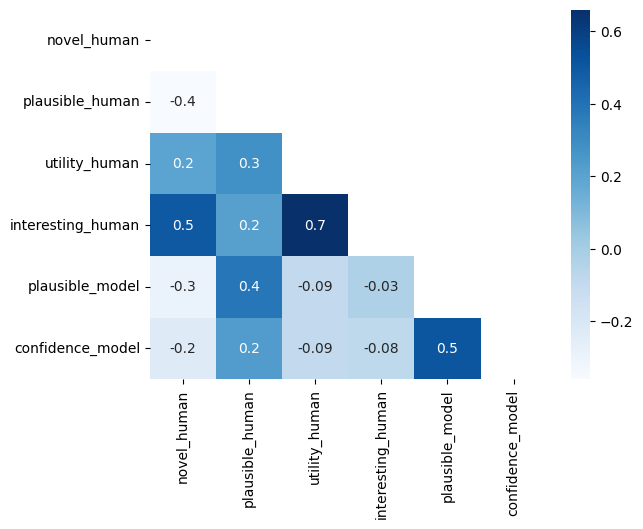

In [34]:
# plot the heatmap

# Create a mask
mask = np.triu(np.ones_like(real_corr.dropna(axis=1,how="all").dropna(axis=0,how="all"), dtype=bool))
# mask = np.triu(np.ones_like(real_corr, dtype=bool))

# sns.heatmap(real_corr, annot=True,mask=mask) 
sns.heatmap(real_corr.dropna(axis=1,how="all").dropna(axis=0,how="all"), cmap="Blues", annot=True,fmt='.1g',mask=mask)
# sns.heatmap(real_corr, cmap="Blues", annot=True,fmt='.1g',mask=mask)

## 5.5/ Human eval Table: Model Alignment

#### cohen kappa agreement
* Note boolean vs 1-4 scale scores for some
* Different from : Table 3: real_vs_fake - Comparison of Human Annotation Scores Between Real and Fake Features. }

In [35]:
real_df[['interesting_human','interesting_model', 'confidence_model',"utility_model"]].drop_duplicates()

# real_df["utility_model"] = pd.to_numeric(real_df["utility_model"],downcast="float")
real_df["utility_model"] = real_df["utility_model"].astype(float)

In [36]:
if "utility_model" not in real_df.columns:
    print("IMPUTING UTIL COL!\n")
    real_df["utility_model"] = 0 # fill in the  col (which was dropped due to all 0 values? )
    
for c in ["novel","plausible","utility","interesting"]:
    print("\n"+c)
    df_sel = real_df[[c+"_human",c+"_model"]].dropna(axis=0,how="any").copy()
    ## map to binary for agreement (or other way round?)
    if not USE_ALT:
        df_sel[c+"_human"] = (df_sel[c+"_human"]>2).astype(int)
    
    if min(df_sel[c+"_human"].nunique(),df_sel[c+"_model"].nunique()) == 1:
    # if len(set(df_sel[c+"_human"]).union(df_sel[c+"_model"])) == 1: ## single label case
    # kappa = 1
        print("one-label")
    else:
        kappa = cohen_kappa_score(df_sel[c+"_human"],df_sel[c+"_model"])
        print(f"cohen kappa: {kappa:.3f}")
        corr = df_sel[c+"_human"].corr(df_sel[c+"_model"]).round(2)
        print("corr:",corr)
    print(df_sel[c+"_human"].mean().round(2)," - Human (boolean) mean")
    print(df_sel[c+"_model"].mean().round(2)," - Model mean")

## interesting to confidence score (has 4 point scale)
print("Interestingness-confidence")
df_sel = real_df[["interesting_human","confidence_model"]].dropna(axis=0,how="any").copy()
print(f'{cohen_kappa_score(df_sel["interesting_human"],df_sel["confidence_model"]):.3f}')


novel
one-label
0.6  - Human (boolean) mean
1.0  - Model mean

plausible
cohen kappa: 0.292
corr: 0.32
0.43  - Human (boolean) mean
0.24  - Model mean

utility
cohen kappa: -0.108
corr: -0.11
0.21  - Human (boolean) mean
0.19  - Model mean

interesting
cohen kappa: 0.005
corr: 0.05
0.31  - Human (boolean) mean
0.99  - Model mean
Interestingness-confidence
0.009


In [37]:
for c in ["novel","plausible","utility","interesting"]:
    print("\n"+c)
    df_sel = real_df[[c+"_human",c+"_model"]].dropna(axis=0,how="any").copy()
    ## map to binary for agreement (or other way round?)
    df_sel[c+"_human"] = (df_sel[c+"_human"]>2).astype(int)
    df_sel[c+"_model"] = (df_sel[c+"_model"]>2).astype(int)
    
    if min(df_sel[c+"_human"].nunique(),df_sel[c+"_model"].nunique()) == 1:
    # if len(set(df_sel[c+"_human"]).union(df_sel[c+"_model"])) == 1: ## single label case
    # kappa = 1
        print("one-label")
    else:
        kappa = cohen_kappa_score(df_sel[c+"_human"],df_sel[c+"_model"])
        print(f"cohen kappa: {kappa:.3f}")
    print(df_sel[c+"_human"].mean().round(2)," - Human (boolean) mean")
    print(df_sel[c+"_model"].mean().round(2)," - Model mean")

## interesting to confidence score (has 4 point scale)
print("Interestingness-confidence")
df_sel = real_df[["interesting_human","confidence_model"]].dropna(axis=0,how="any").copy()
print(f'{cohen_kappa_score(df_sel["interesting_human"],df_sel["confidence_model"]):.3f}')


novel
one-label
0.6  - Human (boolean) mean
0.0  - Model mean

plausible
one-label
0.43  - Human (boolean) mean
0.0  - Model mean

utility
one-label
0.21  - Human (boolean) mean
0.0  - Model mean

interesting
one-label
0.31  - Human (boolean) mean
0.0  - Model mean
Interestingness-confidence
0.009


### ALT, 01 agreement:

## using 1-4 scale:
```
novel
cohen kappa: -0.008
3.12  - Human (boolean) mean
2.94  - Model mean

plausible
cohen kappa: 0.185
2.6  - Human (boolean) mean
2.27  - Model mean

utility
cohen kappa: -0.135
2.14  - Human (boolean) mean
2.07  - Model mean

interesting
cohen kappa: -0.077
2.4  - Human (boolean) mean
2.29  - Model mean
Interestingness-confidence
-0.077
```


Using 0/1 scale (>2):

```
novel
cohen kappa: 0.116
0.74  - Human (boolean) mean
0.93  - Model mean

plausible
cohen kappa: 0.340
0.51  - Human (boolean) mean
0.27  - Model mean

utility
cohen kappa: -0.148
0.25  - Human (boolean) mean
0.14  - Model mean

interesting
cohen kappa: -0.103
0.42  - Human (boolean) mean
0.29  - Model mean
Interestingness-confidence
-0.077
```


ORIGINAL (submodels, rag, not 01), with 0/1 scale:
```
novel
one-label
0.74  - Human (boolean) mean
1.0  - Model mean

plausible
cohen kappa: 0.306
0.52  - Human (boolean) mean
0.26  - Model mean

utility
cohen kappa: -0.149
0.25  - Human (boolean) mean
0.2  - Model mean

interesting
cohen kappa: 0.017
0.42  - Human (boolean) mean
0.99  - Model mean
Interestingness-confidence
0.014
```

In [38]:
real_df[["utility_human","utility_model"]]

,utility_human,utility_model
0,3.0,0.0
1,3.0,0.0
2,3.0,1.0
3,2.0,0.0
4,2.0,0.0
...,...,...
176,NaN,NaN
177,NaN,NaN
178,2.0,NaN
179,2.0,NaN


## more analysis - less clean

In [39]:
# Recompute statistical summaries and agreement metrics with the refined dataset
stats_summary_refined, agreement_metrics_refined = compute_statistics_and_agreement_with_validation(refined_data)

# Display the refined statistical summaries
display(stats_summary_refined.round(2))

# Display the refined agreement metrics
agreement_metrics_refined


/home/ddofer/anaconda3/envs/Medrag/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ddofer/anaconda3/envs/Medrag/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,Category,Real Mean (Human),Real Std (Human),Real Mean (Model),Real Std (Model),Fake Mean (Human),Fake Mean (Model),T-Test p-value (Human),T-Test p-value (Model)
0,novel_human,2.78,1.01,1.00,0.00,NaN,NaN,NaN,NaN
1,plausible_human,2.46,0.95,0.24,0.43,NaN,NaN,NaN,NaN
2,interesting_human,2.09,0.80,0.99,0.08,NaN,NaN,NaN,NaN


{'novel_human': {'Pearson Correlation': nan, 'Cohen Kappa': 0.0, 'MCC': 0.0},
 'plausible_human': {'Pearson Correlation': 0.3773701024468639,
  'Cohen Kappa': 0.0,
  'MCC': 0.0},
 'interesting_human': {'Pearson Correlation': 0.008871981784624044,
  'Cohen Kappa': 0.0,
  'MCC': 0.0}}

In [40]:
import matplotlib.pyplot as plt

def plot_distributions(real_data, target_name):
    """
    Plot the distributions of human and model scores for each category.
    """
    categories = ['Novel?', 'Plausible-Makes sense?', 'Utility?', 'Interesting?_human']
    model_columns = ['novel', 'plausible', 'Interesting?_model']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (human_col, model_col) in enumerate(zip(categories, model_columns)):
        valid_data = real_data[[human_col, model_col]].dropna()
        
        axes[i].hist(valid_data[human_col], bins=5, alpha=0.6, label='Human', color='blue')
        axes[i].hist(valid_data[model_col], bins=5, alpha=0.6, label='Model', color='orange')
        axes[i].set_title(f"{target_name}: {human_col}")
        axes[i].set_xlabel('Score')
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# # Plot distributions for oesophagus cancer and gallstones
# plot_distributions(real_oesophagus, "Oesophagus Cancer")
# plot_distributions(real_gallstone, "Gallstones")


### Look at human picks

In [41]:
real_df.query('interesting_human>2').shape[0]

51

In [42]:
import yaml

In [43]:
real_df[ 'target'].value_counts()

target
oesophagus cancer                                                                               88
Gout                                                                                            50
(Cholelithiasis) OR (Gallstone) OR (Gallbladder disease) OR (cholecystitis) OR (Cholangitis)    43
Name: count, dtype: int64

In [44]:
df_cand = real_df.query('(interesting_human>2) | (novel_human>3)')[['feature_name', 'comments','novel_human', 'plausible_human',
       'utility_human', 'interesting_human', 'corr', 'target']]

In [45]:
text = yaml.dump(
    df_cand.query('(interesting_human>2) & (target=="oesophagus cancer")')[['feature_name', 'comments','novel_human', 'plausible_human',
       'utility_human', 'interesting_human', 'corr', 'target']].to_dict(
        # orient='records'
    ),
    sort_keys=False, width=72, indent=4,
    default_flow_style=None)

print(text)

feature_name: {0: (MEL) melanoma genetic risk, 1: Apolipoprotein A1, 3: Treatment/medication
        code | Array 0__atenolol, 4: (ISS) ischaemic stroke genetic risk,
    5: (RA) rheumatoid arthritis genetic risk, 9: Apolipoprotein B, 10: Average
        Diameter for VLDL Particles, 11: (AST) asthma genetic risk, 14: (VTE)
        venous thromboembolic disease genetic risk, 15: Acetone, 19: Long-term/recurrent
        antibiotics as child or teenager_No, 23: 'Non-cancer illness code,
        self-reported | Array 0__hypertension', 24: (EOC) epithelial ovarian
        cancer genetic risk, 27: 3-Hydroxybutyrate, 31: Concentration of Very
        Small VLDL Particles, 34: (SLE) systemic lupus erythematosus genetic
        risk, 38: (HBA1C_DF) glycated haemoglobin genetic risk, 39: Acetoacetate,
    40: Wheeze or whistling in the chest in last year_Yes, 41: Vitamin D,
    47: Treatment/medication code | Array 0__atenolol, 55: (AST) asthma genetic
        risk, 63: Long-term/recurrent antib

In [46]:
# real_df.query('(interesting_human>3) | (novel_human>3)')[['feature_name', 'comments', 'novel_human','plausible_human',
#         'corr',
#        'utility_human', 'interesting_human']]

In [47]:
df_cand.query('(interesting_human>2) & (target=="oesophagus cancer")')[['feature_name', 'comments','novel_human', 'plausible_human',
       'utility_human', 'interesting_human', 'corr']]#.to_clipboard()

,feature_name,comments,novel_human,plausible_human,utility_human,interesting_human,corr
0,(MEL) melanoma genetic risk,NaN,4.0,2.0,3.0,3.0,0.017
1,Apolipoprotein A1,very stronk link between esophageal and BMI /...,3.0,3.0,3.0,3.0,0.008
3,Treatment/medication code | Array 0__atenolol,NaN,4.0,2.0,2.0,3.0,0.024
4,(ISS) ischaemic stroke genetic risk,hyperlipidemia and BMI is a risk factor for both,4.0,2.0,2.0,3.0,0.009
5,(RA) rheumatoid arthritis genetic risk,NaN,4.0,2.0,2.0,3.0,0.009
9,Apolipoprotein B,hard for me to judge - again opposite relation...,4.0,2.0,3.0,3.0,-0.012
10,Average Diameter for VLDL Particles,same as ApoA explenation,3.0,3.0,3.0,3.0,0.013
11,(AST) asthma genetic risk,same as Age asthma diagnosed_10,4.0,2.0,2.0,3.0,0.014
14,(VTE) venous thromboembolic disease genetic risk,VTE unlike CAD\ISS is less related to hyperlip...,4.0,2.0,3.0,3.0,-0.012
15,Acetone,NaN,3.0,3.0,2.0,3.0,0.022


In [48]:
# df_cand.query('(interesting_human>2) & (target!="oesophagus cancer")')[['feature_name', 'comments','novel_human', 'plausible_human',
#        'utility_human', 'interesting_human']]#.to_clipboard()

## Interestingness by target
* For text

In [49]:
df_temp = real_df.copy()
df_temp["int"] = df_temp["interesting_human"]>2
df_temp.groupby("target")["int"].mean().round(2)

target
(Cholelithiasis) OR (Gallstone) OR (Gallbladder disease) OR (cholecystitis) OR (Cholangitis)    0.37
Gout                                                                                            0.18
oesophagus cancer                                                                               0.30
Name: int, dtype: float64

In [50]:
df_temp["int"].mean()

0.281767955801105